In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time
import scipy

In [2]:
%matplotlib inline

In [3]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


# Import network, layers and functions

In [4]:
from nnet_gpu.network import Sequential
from nnet_gpu.layers import conv2d,max_pool,flatten,dense,dropout,BatchNormalization,globalAveragePool
from nnet_gpu import optimizers
from nnet_gpu import functions
import numpy as np
import cupy as cp

# Make Sequential Model

In [5]:
model=Sequential()
model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu,input_shape=(32,32,3)))
model.add(conv2d(num_kernels=32,kernel_size=3,stride=(2,2),activation=functions.relu))
model.add(BatchNormalization())
# model.add(max_pool())
model.add(dropout(0.1))
model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
model.add(conv2d(num_kernels=64,kernel_size=3,stride=(2,2),activation=functions.relu))
model.add(BatchNormalization())
# model.add(max_pool())
model.add(dropout(0.2))
model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
model.add(conv2d(num_kernels=128,kernel_size=3,stride=(2,2),activation=functions.relu))
model.add(BatchNormalization())
# model.add(globalAveragePool())
# model.add(max_pool())
model.add(dropout(0.3))
model.add(flatten())
model.add(dense(128,activation=functions.relu))
model.add(BatchNormalization())
model.add(dense(10,activation=functions.softmax))

AttributeError: 'NoneType' object has no attribute 'shape'

# View Model Summary

In [ ]:
model.summary()

# Compile model with optimizer, loss and lr

In [7]:
model.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

# Reload saved model weights

In [8]:
# model.load_weights("cifar.dump")

# Train model

In [9]:
btsz=128

In [10]:
itr_train=dt.data_augment(btsz)

In [11]:
dxinp=cp.asarray(dt.training_images)
dyinp=cp.asarray(dt.training_labels)
dxtest=cp.asarray(dt.test_images)
dytest=cp.asarray(dt.test_labels)

In [12]:
model.validate((dxtest,dytest),256)

Validation Accuracy: 0.1041 - val_loss: 4.9765 - Time: 8.761s


In [13]:
model.fit(X_inp=dxinp,labels=dyinp,batch_size=btsz,epochs=5,validation_data=(dxtest,dytest),shuffle=False)

EPOCH: 1 / 5
Progress:  50000 / 50000  - 0s - 0.375s/sample - loss: 1.1126 - accuracy: 0.5381 - Time: 157.801s
Validation Accuracy: 0.5254 - val_loss: 1.3176 - Time: 9.509s
EPOCH: 2 / 5
Progress:  50000 / 50000  - 0s - 0.375s/sample - loss: 0.9139 - accuracy: 0.6330 - Time: 157.910s
Validation Accuracy: 0.6246 - val_loss: 1.1062 - Time: 9.510s
EPOCH: 3 / 5
Progress:  50000 / 50000  - 0s - 0.375s/sample - loss: 0.8154 - accuracy: 0.6794 - Time: 157.865s
Validation Accuracy: 0.6734 - val_loss: 0.9856 - Time: 9.508s
EPOCH: 4 / 5
Progress:  50000 / 50000  - 0s - 0.375s/sample - loss: 0.6851 - accuracy: 0.7108 - Time: 157.894s
Validation Accuracy: 0.6935 - val_loss: 0.9215 - Time: 9.506s
EPOCH: 5 / 5
Progress:  50000 / 50000  - 0s - 0.384s/sample - loss: 0.5857 - accuracy: 0.7684 - Time: 161.424s
Validation Accuracy: 0.7161 - val_loss: 0.9095 - Time: 9.508s


In [84]:
drs    ##timings

{'0 conv2d': (0.023433208465576172, 0.0223386287689209),
 '1 BatchNormalization': (0.014306068420410156, 0.042482614517211914),
 '2 max_pool': (0.031503915786743164, 0.0055539608001708984),
 '3 dropout': (0.012694835662841797, 0.0007596015930175781),
 '4 conv2d': (0.03257465362548828, 0.06492161750793457),
 '5 BatchNormalization': (0.006804227828979492, 0.011799097061157227),
 '6 max_pool': (0.013078927993774414, 0.002126932144165039),
 '7 dropout': (0.006076812744140625, 0.0004172325134277344),
 '8 conv2d': (0.022433042526245117, 0.061127424240112305),
 '9 BatchNormalization': (0.004527091979980469, 0.016093969345092773),
 '10 max_pool': (0.006756782531738281, 0.0018391609191894531),
 '11 dropout': (0.0047283172607421875, 0.0007653236389160156),
 '12 flatten': (5.0067901611328125e-06, 8.106231689453125e-06),
 '13 dense': (0.0030829906463623047, 0.017281532287597656),
 '14 BatchNormalization': (0.0003304481506347656, 0.0006730556488037109),
 '15 dropout': (0.0011906623840332031, 9.3698

In [21]:
model.otms

0.02379584312438965

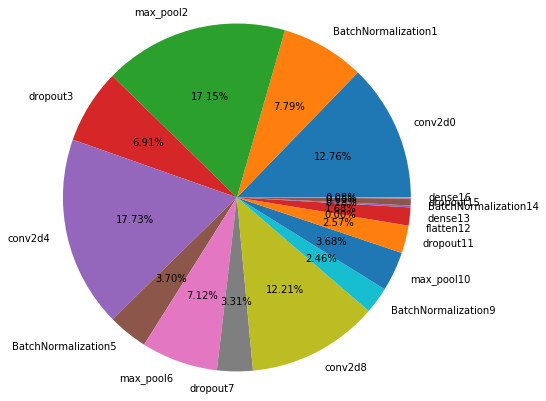

In [76]:
plt.pie(model.ftms/model.ftms.sum(),labels=ly,autopct='%1.2f%%',radius=2)
plt.show()

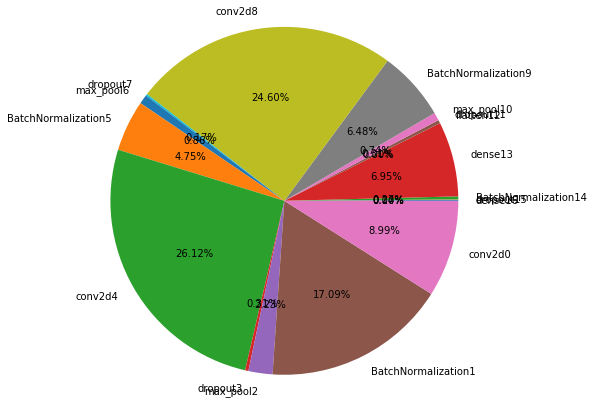

In [75]:
plt.pie(model.btms/model.btms.sum(),labels=ly[::-1],autopct='%1.2f%%',radius=2)
plt.show()

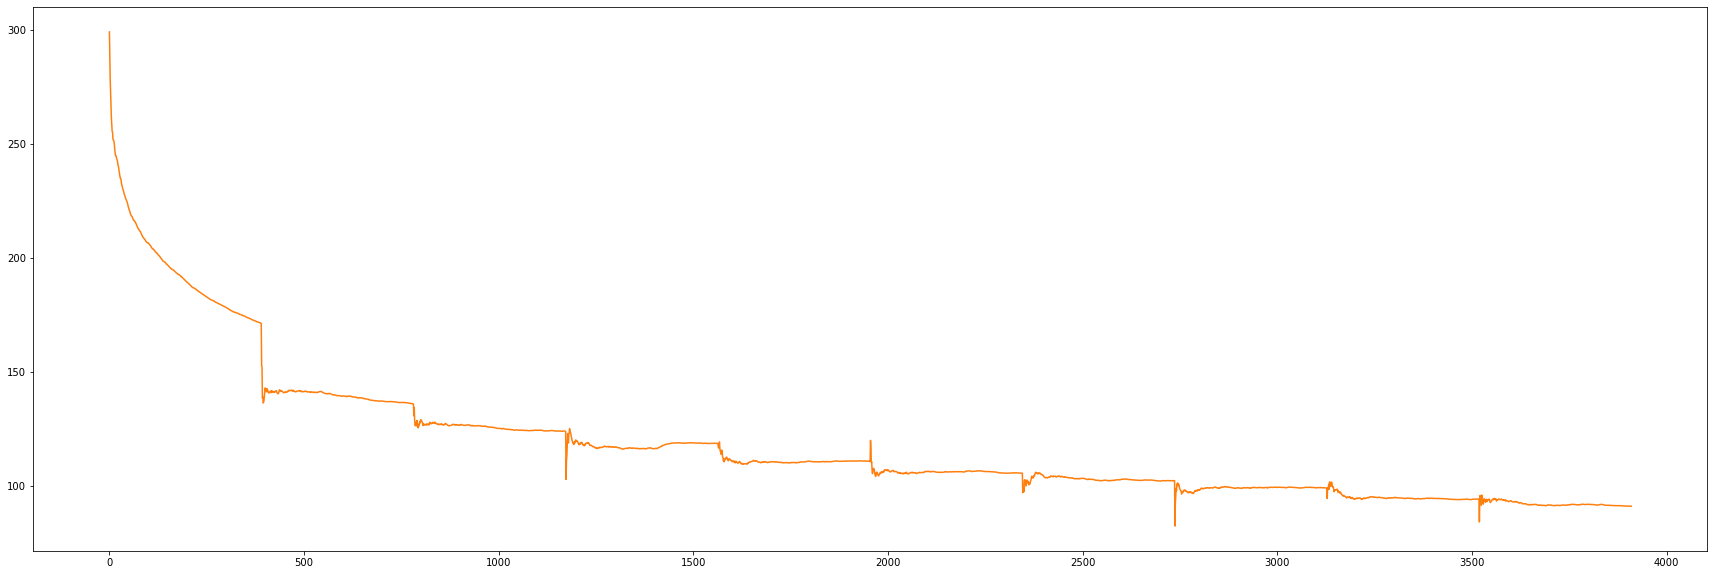

In [15]:
plt.figure(figsize=(30,10))
plt.plot(losses,color='#ff7f0e')
plt.show()

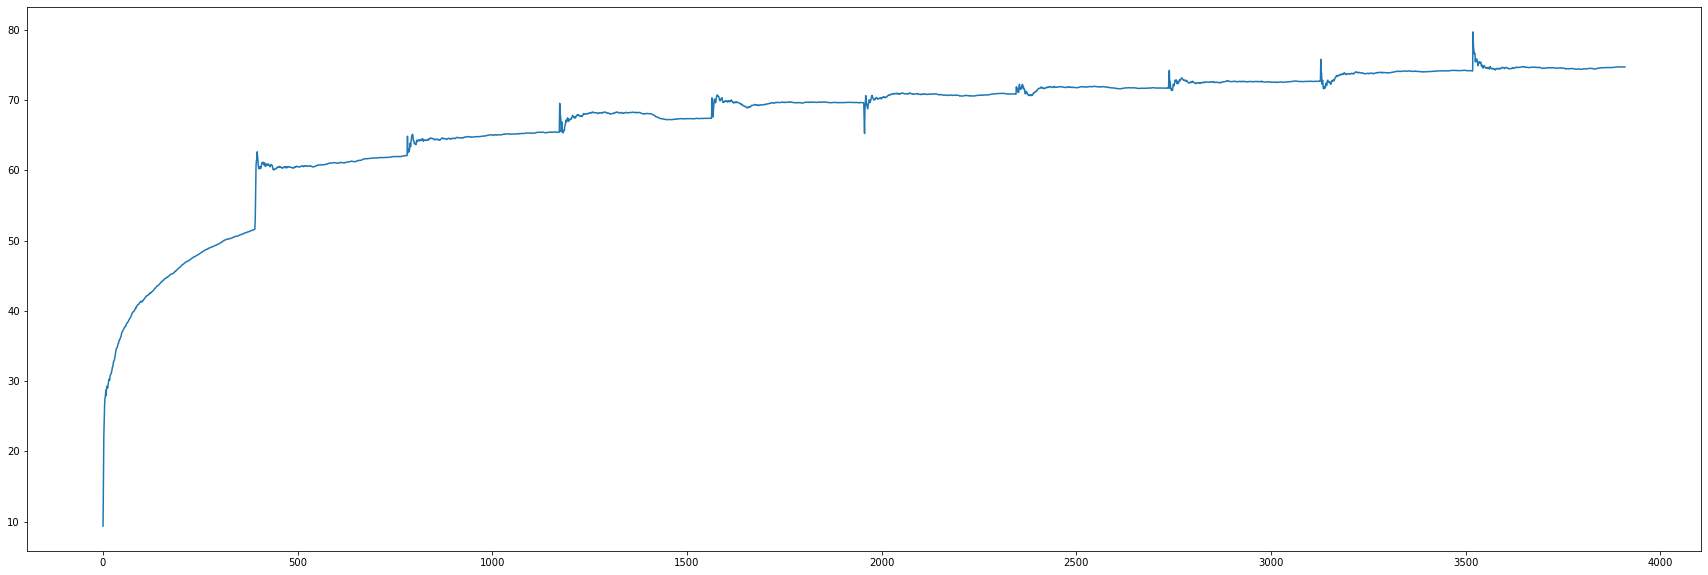

In [16]:
plt.figure(figsize=(30,10))
plt.plot(train_acc)#,color='#ff7f0e')
plt.show()

In [22]:
model.save_weights("cifar.dump")

Prediction:  deer 
Correct answer:  deer


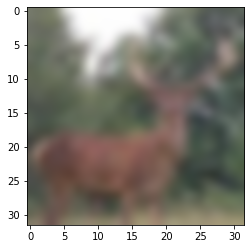

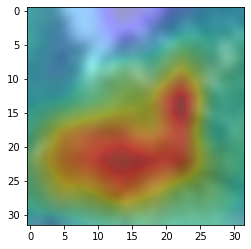

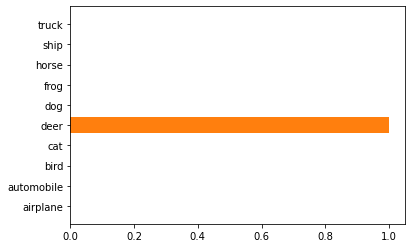

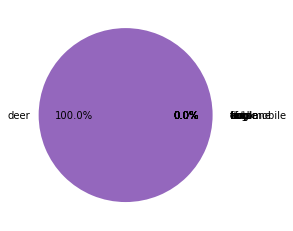

In [53]:
ck=np.random.randint(0,10000)
# inp,y_inp=dt.batch_gen(size=1,ck=ck)
inp = dt.test_images[ck:ck+1].reshape(-1,32,32,3)
y_inp = dt.test_labels[ck:ck+1]
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
logits=logits[0]
print("Prediction: ",dt.names[int(ans[0])],"\nCorrect answer: ",dt.names[int(cor[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.imshow(inp[0],interpolation='bicubic')
features=model.sequence[11].a_out[0]
ans_weights=model.sequence[-1].weights[:,ans[0]]
heatMap=scipy.ndimage.zoom(features.dot(ans_weights),(4,4), order=1).squeeze()
plt.imshow(heatMap,cmap='jet',interpolation='bicubic',alpha=0.4)
plt.show()
plt.barh(range(len(logits)),logits,color='#ff7f0e')
plt.yticks(range(len(logits)),dt.names)
# plt.xticks([])
plt.show()
explode=np.zeros(10)
explode[ans]=0.1
plt.pie(logits,labels=dt.names,autopct='%1.1f%%',explode=explode)
plt.show()

In [77]:
# itr_test=dt.data_augment(10)

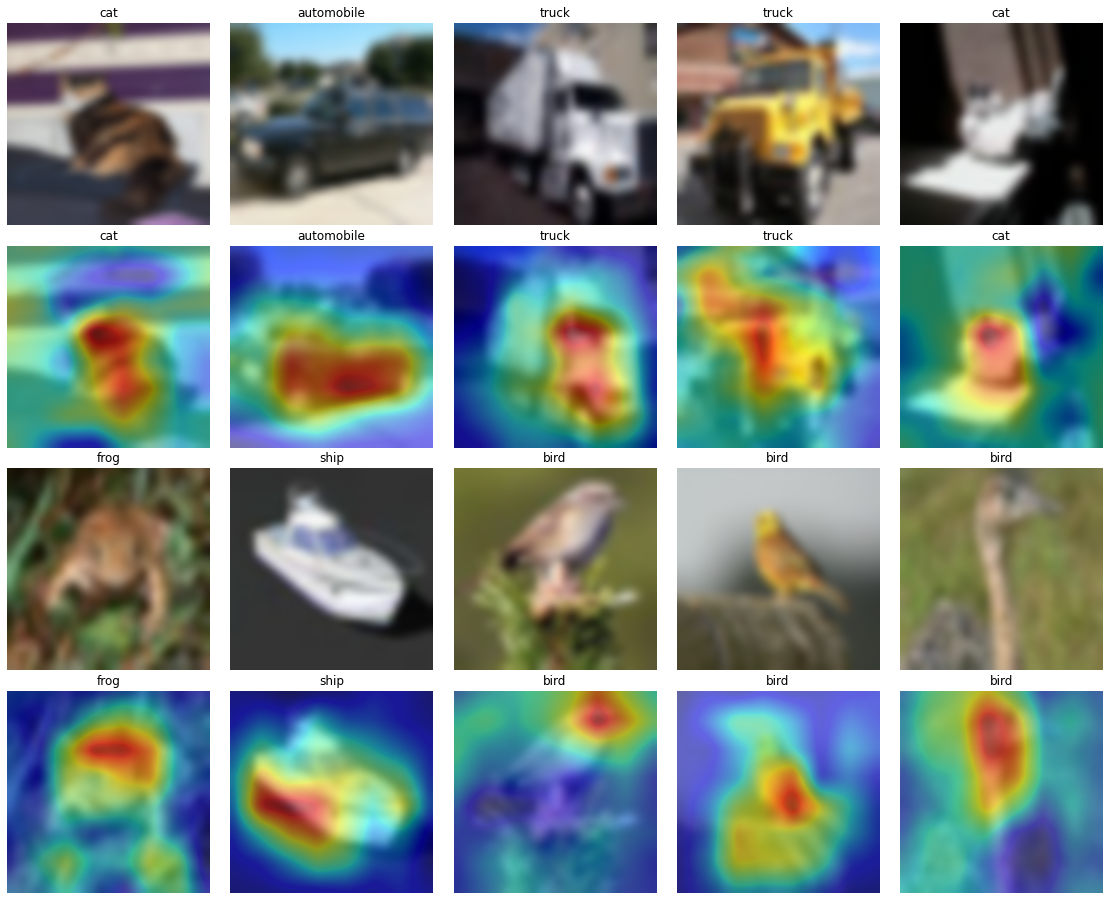

In [135]:
num=10
ck=np.random.randint(0,10000,num)
# inp,y_inp=itr_test.next()
inp,y_inp = dt.test_images[ck].reshape(-1,32,32,3),dt.test_labels[ck]
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
fig, ax = plt.subplots(nrows=4,ncols=5,figsize=[20,16],gridspec_kw = {'wspace':0, 'hspace':0.1})
fig.patch.set_facecolor('white')
for i in range(ax.shape[0]//2):
    for j in range(ax.shape[1]):
        idx=i*5+j
        af=ax[i*2,j]
        ah=ax[i*2+1,j]
        af.axis('off')
        ah.axis('off')
        af.set_title(dt.names[int(cor[idx])])
        af.imshow(inp[idx],interpolation='bicubic')
        features=model.sequence[11].a_out[idx]
        ans_weights=model.sequence[-1].weights[:,ans[idx]]
        heatMap=scipy.ndimage.zoom(features.dot(ans_weights),(4,4), order=1).squeeze()
        ah.set_title(dt.names[int(ans[idx])])
        ah.imshow(inp[idx],interpolation='bicubic')
        ah.imshow(heatMap,cmap='jet',interpolation='bicubic',alpha=0.5)

In [144]:
import cv2

In [145]:
img=plt.imread("test.jpg")

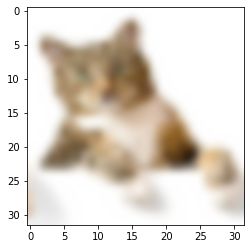

In [146]:
rsz=cv2.resize(img,(32,32),interpolation = cv2.INTER_AREA)
plt.imshow(rsz,interpolation='bicubic')

In [147]:
logits=model.predict(rsz.reshape(1,32,32,3))
ans=logits.argmax(axis=1)
logits=logits[0]
print("Prediction: ",dt.names[int(ans[0])])

Prediction:  bird


In [148]:
np.asarray(dt.names)[model.sequence[-1].z_out.argsort()[:,::-1]]

array([['bird', 'cat', 'dog', 'horse', 'frog', 'automobile', 'deer',
        'airplane', 'ship', 'truck']], dtype='<U10')

In [ ]:
features=model.sequence[11].a_out[0]
for i in model.sequence[-1].z_out.argsort()[:,::-1][0]:
    plt.imshow(rsz,interpolation='bicubic')
    ans_weights=model.sequence[-1].weights[:,i]
    heatMap=scipy.ndimage.zoom(features.dot(ans_weights),(4,4), order=1).squeeze()
    plt.imshow(heatMap,cmap='jet',interpolation='bicubic',alpha=0.5)
    plt.axis('off')
    plt.title(dt.names[i])
    plt.show()